In [1]:
# import libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import re
import numpy as np
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack

import pickle
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
# load the dataset
df_train = pd.read_csv('df_eda.csv')
print(df_train.shape)
df_train.head()

(1482531, 14)


,train_id,name,item_condition_id,brand_name,price,shipping,item_description,price_log,category1,category2,category3,category4,category5,branded
0,0,MLB Cincinnati Reds T Shirt Size XL,3,missing,10.0,1,No description yet,2.397895,Men,Tops,T-shirts,No category,No category,0
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,3.970292,Electronics,Computers & Tablets,Components & Parts,No category,No category,1
2,2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2.397895,Women,Tops & Blouses,Blouse,No category,No category,1
3,3,Leather Horse Statues,1,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...,3.583519,Home,Home Décor,Home Décor Accents,No category,No category,0
4,4,24K GOLD plated rose,1,missing,44.0,0,Complete with certificate of authenticity,3.806662,Women,Jewelry,Necklaces,No category,No category,0


In [3]:
min(df_train['price'].values)

0.0

### Getting brand names of missing brand from Product names

In [4]:
# unique brand names
unique_brand = set(df_train.loc[df_train['brand_name']!="missing", 'brand_name'].values)
print(len(unique_brand))
missing_brand = len(df_train.loc[df_train['brand_name']=="missing"])
print(missing_brand)

4809
632679


In [5]:
#https://www.kaggle.com/valkling/mercari-rnn-2ridge-models-with-notes-0-42755
def brandfinder(line):
    brand = line[0]
    name = line[1]
    namesplit = name.split(' ')
    if brand == 'missing':
        for x in namesplit:
            if x in unique_brand:
                return name
    if name in unique_brand:
        return name
    return brand

In [6]:
#https://stackoverflow.com/questions/18603270/progress-indicator-during-pandas-operations

tqdm.pandas()
df_train['brand_name'] = df_train[['brand_name','name']].progress_apply(brandfinder, axis = 1)
# test_df['brand_name'] = test_df[['brand_name','name']].apply(brandfinder, axis = 1)
print(missing_brand-len(df_train.loc[df_train['brand_name'] == 'missing']))

100%|█████████████████████████████| 1482531/1482531 [01:08<00:00, 21704.83it/s]


128886


### Text Preprocessing and Transformation

In [7]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

def text_preprocess(data):
    preprocessed = []

    for sentence in tqdm(data):
        sent = decontracted(sentence)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\n', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)

        sent = ' '.join(e for e in sent.split() if e not in stopwords)
        preprocessed.append(sent.lower().strip())
    return preprocessed

In [8]:
# 'No description yet' needs to be replaced, as the word 'No' may bias for negative sentiment

#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.replace.html
df_train['name'].replace([np.nan], '', inplace=True)
df_train['item_description'].replace([np.nan,'No description yet'], '', inplace=True)

In [9]:
df_train['name_preprocess'] = text_preprocess(df_train['name'])
df_train['desc_preprocess'] = text_preprocess(df_train['item_description'])
df_train.head()

100%|██████████████████████████████| 1482531/1482531 [03:26<00:00, 7165.41it/s]


,train_id,name,item_condition_id,brand_name,price,shipping,item_description,price_log,category1,category2,category3,category4,category5,branded,name_preprocess,desc_preprocess
0,0,MLB Cincinnati Reds T Shirt Size XL,3,MLB Cincinnati Reds T Shirt Size XL,10.0,1,,2.397895,Men,Tops,T-shirts,No category,No category,0,mlb cincinnati reds t shirt size xl,
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,3.970292,Electronics,Computers & Tablets,Components & Parts,No category,No category,1,razer blackwidow chroma keyboard,this keyboard great condition works like came ...
2,2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2.397895,Women,Tops & Blouses,Blouse,No category,No category,1,ava viv blouse,adorable top hint lace key hole back the pale ...
3,3,Leather Horse Statues,1,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...,3.583519,Home,Home Décor,Home Décor Accents,No category,No category,0,leather horse statues,new tags leather horses retail rm stand foot h...
4,4,24K GOLD plated rose,1,missing,44.0,0,Complete with certificate of authenticity,3.806662,Women,Jewelry,Necklaces,No category,No category,0,24k gold plated rose,complete certificate authenticity


__Split data into Train and Test__

In [10]:
train, test = train_test_split(df_train, test_size=0.33, random_state=0)
print(train.shape)
print(test.shape)

(993295, 16)
(489236, 16)


In [11]:
y_train = train['price'].values
y_test = test['price'].values
print(y_train.shape)
print(y_test.shape)

(993295,)
(489236,)


In [12]:
y_log_train = train['price_log'].values
y_log_test = test['price_log'].values
print(y_log_train.shape)
print(y_log_test.shape)

(993295,)
(489236,)


In [13]:
file = open('./preprocess_outputs/y_train', 'wb')
pickle.dump(y_train, file)
file.close()

file = open('./preprocess_outputs/y_test', 'wb')
pickle.dump(y_test, file)
file.close()

file = open('./preprocess_outputs/y_log_train', 'wb')
pickle.dump(y_log_train, file)
file.close()

file = open('./preprocess_outputs/y_log_test', 'wb')
pickle.dump(y_log_test, file)
file.close()

In [14]:
train.to_csv('./preprocess_outputs/train_preprocess.csv', index=False)
test.to_csv('./preprocess_outputs/test_preprocess.csv', index=False)

In [15]:
# train = pd.read_csv('./preprocess_outputs/train_preprocess.csv')
# test = pd.read_csv('./preprocess_outputs/test_preprocess.csv')
# print(train.shape)
# print(test.shape)

### Encoding brand_name

In [16]:
from datetime import datetime
print(datetime.now())

2020-09-15 23:55:07.204704


In [17]:
%%time

encode = LabelBinarizer(sparse_output=True)
train_brand_encode = encode.fit_transform(train['brand_name'].astype('category'))
test_brand_encode = encode.transform(test['brand_name'].astype('category'))
print(train_brand_encode.shape)
print(test_brand_encode.shape)

(993295, 82230)
(489236, 82230)
Wall time: 58min 39s


In [18]:
print(datetime.now())

2020-09-16 00:53:46.833304


In [19]:
# %%time

# encode = LabelBinarizer(sparse_output=True)
# train_brand_encode = encode.fit_transform(train['brand_name'].astype('category'))
# test_brand_encode = encode.transform(test['brand_name'].astype('category'))
# print(train_brand_encode.shape)
# print(test_brand_encode.shape) # (, 118701)

## Wall time: 1h 9min 38s

In [20]:
file = open('./preprocess_outputs/train_brand_encode', 'wb')
pickle.dump(train_brand_encode, file)
file.close()

file = open('./preprocess_outputs/test_brand_encode', 'wb')
pickle.dump(test_brand_encode, file)
file.close()

## Encoding shipping, item_condition, branded

In [21]:
# Converting text data to vectors

def ohe(train_data, test_data):
    ohe = OneHotEncoder(sparse=False)
    ohe.fit(train_data)
    
    ohe_train = ohe.transform(train_data)
    ohe_test = ohe.transform(test_data)
    
    return ohe_train, ohe_test

In [22]:
train_shipping_ohe, test_shipping_ohe = ohe(train['shipping'].values.reshape(-1,1), test['shipping'].values.reshape(-1,1))
train_item_cond_ohe, test_item_cond_ohe = ohe(train['item_condition_id'].values.reshape(-1,1), test['item_condition_id'].values.reshape(-1,1))
train_branded_ohe, test_branded_ohe = ohe(train['branded'].values.reshape(-1,1), test['branded'].values.reshape(-1,1))

print(train_shipping_ohe.shape, test_shipping_ohe.shape)
print(train_item_cond_ohe.shape, test_item_cond_ohe.shape)
print(train_branded_ohe.shape, test_branded_ohe.shape)

(993295, 2) (489236, 2)
(993295, 5) (489236, 5)
(993295, 2) (489236, 2)


In [23]:
file = open('./preprocess_outputs/train_shipping_ohe', 'wb')
pickle.dump(train_shipping_ohe, file)
file.close()
file = open('./preprocess_outputs/test_shipping_ohe', 'wb')
pickle.dump(test_shipping_ohe, file)
file.close()

file = open('./preprocess_outputs/train_item_cond_ohe', 'wb')
pickle.dump(train_item_cond_ohe, file)
file.close()
file = open('./preprocess_outputs/test_item_cond_ohe', 'wb')
pickle.dump(test_item_cond_ohe, file)
file.close()

file = open('./preprocess_outputs/train_branded_ohe', 'wb')
pickle.dump(train_branded_ohe, file)
file.close()
file = open('./preprocess_outputs/test_branded_ohe', 'wb')
pickle.dump(test_branded_ohe, file)
file.close()

## Encoding text features

In [24]:
train['desc_preprocess'].fillna("", inplace=True)
print(train['desc_preprocess'].isna().sum())

test['desc_preprocess'].fillna("", inplace=True)
print(test['desc_preprocess'].isna().sum())

0
0


In [25]:
%%time

vectorizer = TfidfVectorizer(max_features=1000000, ngram_range=(1,2))
vectorizer.fit(train['desc_preprocess'])

train_desc_tfidf = vectorizer.transform(train['desc_preprocess'])
test_desc_tfidf = vectorizer.transform(test['desc_preprocess'])

print(train_desc_tfidf.shape)
print(test_desc_tfidf.shape)

(993295, 1000000)
(489236, 1000000)
Wall time: 3min 10s


In [26]:
file = open('./preprocess_outputs/train_desc_tfidf', 'wb')
pickle.dump(train_desc_tfidf, file)
file.close()

file = open('./preprocess_outputs/test_desc_tfidf', 'wb')
pickle.dump(test_desc_tfidf, file)
file.close()

## Encoding categories

In [27]:
%%time

train["category1"] = train["category1"].apply(lambda x: "" if (x == "No category") else x)
train["category2"] = train["category2"].apply(lambda x: "" if (x == "No category") else x)
train["category3"] = train["category3"].apply(lambda x: "" if (x == "No category") else x)
train["category4"] = train["category4"].apply(lambda x: "" if (x == "No category") else x)
train["category5"] = train["category5"].apply(lambda x: "" if (x == "No category") else x)

test["category1"] = test["category1"].apply(lambda x: "" if (x == "No category") else x)
test["category2"] = test["category2"].apply(lambda x: "" if (x == "No category") else x)
test["category3"] = test["category3"].apply(lambda x: "" if (x == "No category") else x)
test["category4"] = test["category4"].apply(lambda x: "" if (x == "No category") else x)
test["category5"] = test["category5"].apply(lambda x: "" if (x == "No category") else x)
# Wall time: 1.77 s

Wall time: 1.77 s


In [28]:
%%time

vectorizer = CountVectorizer()
vectorizer.fit(train['category1'])
train_cat1_bow = vectorizer.transform(train['category1'])
test_cat1_bow = vectorizer.transform(test['category1'])

vectorizer = CountVectorizer()
vectorizer.fit(train['category2'])
train_cat2_bow = vectorizer.transform(train['category2'])
test_cat2_bow = vectorizer.transform(test['category2'])

vectorizer = CountVectorizer()
vectorizer.fit(train['category3'])
train_cat3_bow = vectorizer.transform(train['category3'])
test_cat3_bow = vectorizer.transform(test['category3'])

vectorizer = CountVectorizer()
vectorizer.fit(train['category4'])
train_cat4_bow = vectorizer.transform(train['category4'])
test_cat4_bow = vectorizer.transform(test['category4'])

vectorizer = CountVectorizer()
vectorizer.fit(train['category5'])
train_cat5_bow = vectorizer.transform(train['category5'])
test_cat5_bow = vectorizer.transform(test['category5'])

print(train_cat1_bow.shape)
print(test_cat1_bow.shape,"\n")
print(train_cat2_bow.shape)
print(test_cat2_bow.shape,"\n")
print(train_cat3_bow.shape)
print(test_cat3_bow.shape,"\n")
print(train_cat4_bow.shape)
print(test_cat4_bow.shape,"\n")
print(train_cat5_bow.shape)
print(test_cat5_bow.shape,"\n")
# Wall time: 53.4 s

(993295, 12)
(489236, 12) 

(993295, 141)
(489236, 141) 

(993295, 954)
(489236, 954) 

(993295, 7)
(489236, 7) 

(993295, 3)
(489236, 3) 

Wall time: 49.4 s


In [29]:
train_cat_bow = hstack((train_cat1_bow, train_cat2_bow, train_cat3_bow, train_cat4_bow, train_cat5_bow))
test_cat_bow = hstack((test_cat1_bow, test_cat2_bow, test_cat3_bow, test_cat4_bow, test_cat5_bow))
print(train_cat_bow.shape)
print(test_cat_bow.shape)

(993295, 1117)
(489236, 1117)


In [30]:
pickle.dump(train_cat_bow, open('./preprocess_outputs/train_cat_bow', 'wb'))
pickle.dump(test_cat_bow, open('./preprocess_outputs/test_cat_bow', 'wb'))

In the EDA, we saw that the median of log price of items per category, shipping status, and brand had significance. So, now, we will try to generate new features based on that.

In [31]:
#https://pandas.pydata.org/pandas-docs/version/0.23.1/generated/pandas.core.groupby.DataFrameGroupBy.agg.html
#https://jamesrledoux.com/code/group-by-aggregate-pandas

In [32]:
# grouped = train['category1']+'/'+train['category2']+'/'+train['category3']+'/'+train['category4']+'/'+train['category5']

In [33]:
grouped_med = train.groupby(['category1','category2','category3','category4','category5','shipping','branded','item_condition_id']).agg({'price_log':np.median})
grouped_med.columns = ['grouped_med']
grouped_med = grouped_med.reset_index()
grouped_med

,category1,category2,category3,category4,category5,shipping,branded,item_condition_id,grouped_med
0,,,,,,0,0,1,2.944439
1,,,,,,0,0,2,2.833213
2,,,,,,0,0,3,2.944439
3,,,,,,0,0,4,2.740319
4,,,,,,0,0,5,2.302585
...,...,...,...,...,...,...,...,...,...
11913,Women,Women's Handbags,Totes & Shoppers,,,1,1,1,3.258097
11914,Women,Women's Handbags,Totes & Shoppers,,,1,1,2,3.367296
11915,Women,Women's Handbags,Totes & Shoppers,,,1,1,3,3.637586
11916,Women,Women's Handbags,Totes & Shoppers,,,1,1,4,3.481122


In [34]:
# Need to put these median values as per the variables involved.
# for that we need to join this master dataset with the transactional dataset

train_med_price_log = train.merge(grouped_med, how='left', on=['category1','category2','category3','category4','category5','shipping','branded','item_condition_id'])
train_med_price_log.head()

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,price_log,category1,category2,category3,category4,category5,branded,name_preprocess,desc_preprocess,grouped_med
0,1381157,Cross Stitch Books,3,missing,12.0,0,3 cross stitch books. Leisure Arts Christmas R...,2.564949,Handmade,Patterns,Cross Stitch,,,0,cross stitch books,3 cross stitch books leisure arts christmas re...,2.564949
1,646655,Sz 7 Crocs flats,2,Crocs,11.0,0,These are like new. I bought them for me. They...,2.484907,Women,Shoes,Flats,,,1,sz 7 crocs flats,these like new i bought they say size 9 they w...,3.091042
2,1199244,BVLGARI OMNIA CORAL 5ml,2,Sephora,14.0,0,5 ml travel size bottle of BVLGARI perfume OMN...,2.708050,Beauty,Fragrance,Women,,,1,bvlgari omnia coral 5ml,5 ml travel size bottle bvlgari perfume omnia ...,2.944439
3,615187,AMERICAN APPAREL Black Leather Hat Cap,3,American Apparel,10.0,1,"AMERICAN APPAREL black leather baseball hat, o...",2.397895,Women,Women's Accessories,Hats,,,1,american apparel black leather hat cap,american apparel black leather baseball hat on...,2.564949
4,836137,Julio Urias 2015 Bowman Orange RC /25,3,Topps,15.0,1,2015 Bowman Draft Orange Parallel Rookie /25 L...,2.772589,Vintage & Collectibles,Trading Cards,Sports,,,1,julio urias 2015 bowman orange rc 25,2015 bowman draft orange parallel rookie 25 lo...,2.079442


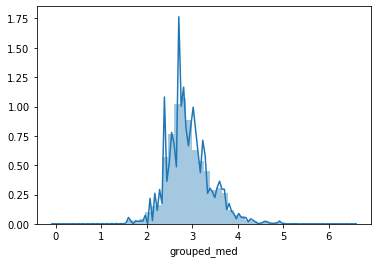

In [35]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.distplot(train_med_price_log['grouped_med'], kde=True)
plt.show()

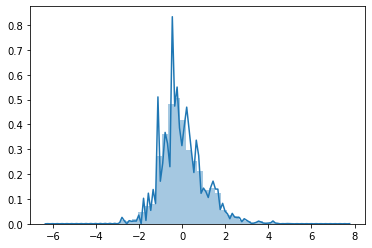

In [36]:
# Since 'grouped_med' is an input feature, we need to standardize it
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

std = StandardScaler(copy=True)
train_grouped_mean_std = std.fit_transform(train_med_price_log['grouped_med'].values.reshape(-1,1))
sns.distplot(train_grouped_mean_std, kde=True)
plt.show()

In [37]:
train_grouped_mean_std.shape

(993295, 1)

In [38]:
pickle.dump(train_grouped_mean_std, open('./preprocess_outputs/train_grouped_mean_std', 'wb'))

Let's check the correlation

In [39]:
train_med_price_log['grouped_med'].corr(train['price_log'])

0.0010999133104708481

The correlation is greater than 0.5. Hence, we can keep this feature.

In [40]:
# Similarly for test dataset
test_med_price_log = test.merge(grouped_med, how='left', on=['category1','category2','category3','category4','category5','shipping','branded','item_condition_id'])
test_med_price_log.head()

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,price_log,category1,category2,category3,category4,category5,branded,name_preprocess,desc_preprocess,grouped_med
0,113674,Brand New Lularoe Randy Large,1,LuLaRoe,35.0,1,,3.583519,Women,Tops & Blouses,T-Shirts,,,1,brand new lularoe randy large,,3.218876
1,46709,Agate glass jewelry holder,1,Anthropologie,21.0,0,It currently holds my hoard of agates but perf...,3.091042,Home,Storage & Organization,Jewelry Boxes & Organizers,,,1,agate glass jewelry holder,it currently holds hoard agates perfect jewelr...,2.740319
2,822909,Air Jordan Retro 6 Men's size 11.5 White,2,Air Jordan,129.0,0,I am selling my Jordan Retro 6s Men's size 11....,4.867534,Men,Shoes,Athletic,,,1,air jordan retro 6 men size 11 5 white,i selling jordan retro 6s men size 11 5 they r...,4.043051
3,1378226,20g nose studs,1,missing,10.0,0,Brand new never been opened. Made of sterling ...,2.397895,Other,Other,Other,,,0,20g nose studs,brand new never opened made sterling silver st...,2.995732
4,528205,Weekend Warrior YL Oils,2,Weekend Warrior YL Oils,32.0,1,2 young living oils Valor2 and peaceNcalming2 ...,3.496508,Women,Other,Other,,,0,weekend warrior yl oils,2 young living oils valor2 peacencalming2 5ml ...,2.564949


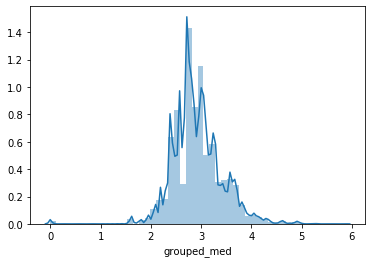

In [41]:
test_med_price_log['grouped_med'].fillna(0, inplace=True)
sns.distplot(test_med_price_log['grouped_med'], kde=True)
plt.show()

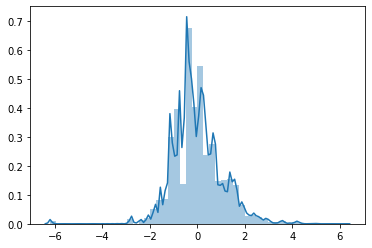

In [42]:
test_grouped_mean_std = std.transform(test_med_price_log['grouped_med'].values.reshape(-1,1))
sns.distplot(test_grouped_mean_std, kde=True)
plt.show()

In [43]:
test_grouped_mean_std.shape

(489236, 1)

In [44]:
pickle.dump(test_grouped_mean_std, open('./preprocess_outputs/test_grouped_mean_std', 'wb'))

Let's check the correlation

In [45]:
test_med_price_log['grouped_med'].corr(test['price_log'])

-0.0032864129944217024

The correlation is greater than 0.5. Hence, we can keep this feature.

## Sentiment Analysis

In [46]:
train['desc_preprocess'].isna().sum()

0

In [47]:
test.fillna("", inplace=True)
print(test['desc_preprocess'].isna().sum())

test.fillna("", inplace=True)
print(test['desc_preprocess'].isna().sum())

0
0


Let's do the sentiment analysis on description of products, using nltk SentimentIntensityAnalyser function

In [48]:
def get_sentiment_score(data):
    
    # Create a SentimentIntensityAnalyzer object. 
    sid_obj = SentimentIntensityAnalyzer()
    senti_scores=[]
  
    # polarity_scores method of SentimentIntensityAnalyzer object gives a sentiment dictionary. 
    # this contains pos, neg, neu, and compound scores.
    for sentence in tqdm(data):
        sentiment_dict = sid_obj.polarity_scores(sentence)
        senti_scores.append(sentiment_dict['compound'])
    
    return np.array(senti_scores).reshape(-1,1)

In [49]:
train_desc_senti = get_sentiment_score(train['desc_preprocess'].astype('str'))
print(train_desc_senti.shape)

100%|████████████████████████████████| 993295/993295 [07:07<00:00, 2325.48it/s]

(993295, 1)


In [50]:
test_desc_senti = get_sentiment_score(test['desc_preprocess'].astype('str'))
print(test_desc_senti.shape)

100%|████████████████████████████████| 489236/489236 [03:08<00:00, 2588.66it/s]


(489236, 1)


In [51]:
pickle.dump(train_desc_senti, open('./preprocess_outputs/train_desc_senti', 'wb'))
pickle.dump(test_desc_senti, open('./preprocess_outputs/test_desc_senti', 'wb'))